# Maximum Likelihood Method



Lets start with a simple Gaussian distribution. 

In [3]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

We can retrieve the probability of events happening, e.g. x=3.0

In [5]:
p_3 = norm.pdf(3.0, 5.0, 3.0)

We can also easily calculate the joint probability of iid (indepenent and identically distributed) events 

In [6]:
p_7 = norm.pdf(7.0, 7.0, 3.0)

joint = p_3*p_7

Assume now that someone is giving us an array of values and ask us to estimate a $p_{model}$ that is a 'good fit' to the gievn data. How we can go about solving this problem with Maximum Likelihood Estimation (MLE)? Notice that as addressed in [3], probability and likelihood have a reverse relationship.  Probability attaches to possible results; likelihood attaches to hypotheses. The likelihood function gives the relative likelihoods of different values for the parameter(s) of the distribution from which the data are assumed to have been drawn, given those data.

Lets plot a couple of $p_{model}$ hypotheses - the data are shown below in the same plot. Both hypotheses are plausible.  

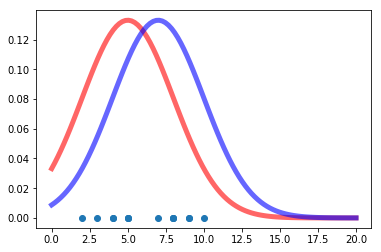

In [7]:
data = [4, 5, 7, 8, 8, 9, 10, 5, 2, 3, 5, 4, 8, 9]

fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 20, 100)
ax.plot(x, norm.pdf(x,5,3),
       'r-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(x, norm.pdf(x,7,3),
       'b-', lw=5, alpha=0.6, label='norm pdf')
ax.plot(data, np.zeros(len(data)).tolist(),'o')

As detailed in Ref [2], its important to safeguard against underflow that may well result from multiplying many numbers (for large datasets) that are less than 1.0 (probabilities). So we do the calculations in the log domain using the identity

$$log(a \times b)=log(a) + log(b)$$

Lets look at a function that calculates the log-likelihood for the two hypotheses above given the data denoted by $x$. 

In [8]:
def compare_data_to_dist(x, mu_1=5, mu_2=7, sd_1=3, sd_2=3):
    ll_1 = 0
    ll_2 = 0
    for i in x:
        ll_1 += np.log(norm.pdf(i, mu_1, sd_1))
        ll_2 += np.log(norm.pdf(i, mu_2, sd_2))
    
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_1, sd_1, ll_1))
    print("The LL of of x for mu = %d and sd = %d is: %.4f" % (mu_2, sd_2, ll_2))


We can readily compate the two hypotheses according to the maximum likelihood criterion. Note that because the $log$ is a monotonic function, the conclusion as to which hypothesis makes the data more likely is the same in the natural or the $log$ domain. 

In [9]:
ll_comparison = compare_data_to_dist(data)

The LL of of x for mu = 5 and sd = 3 is: -33.9679
The LL of of x for mu = 7 and sd = 3 is: -33.3013


It seems that the second hypothesis 

$$p_{model}(x|\mathbf{w}) = N(x | [\mu_2, \sigma_2^2])$$

is preferred compared to the first. 

We can now start searching the hypothesis space (parameter space) for the best parameter set $\mathbf w$. 

The max LL for sd 0.50 is 167.88
The max LL for sd 1.50 is 36.84
The max LL for sd 2.50 is 32.28
The max LL for sd 3.50 is 33.77
The max LL for sd 4.50 is 35.96


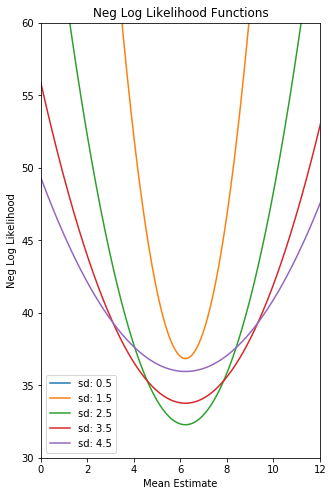

In [10]:
# Plot the Negative Log Likelihood Functions for different values of mu 
# and sigma
def plot_ll(x):
    plt.figure(figsize=(5,8))
    plt.title("Neg Log Likelihood Functions")
    plt.xlabel("Mean Estimate")
    plt.ylabel("Neg Log Likelihood")
    plt.ylim(30, 60)
    plt.xlim(0, 12)
    mu_set = np.linspace(0, 16, 1000)
    sd_set = [.5, 1.5, 2.5, 3.5, 4.5]
    max_val = max_val_location = None
    for i in sd_set:
        ll_array = []
        
        for j in mu_set:
            temp_mm = 0
            
            for k in x:
                temp_mm += np.log(norm.pdf(k, j, i)) # The LL function
            ll_array.append(-temp_mm) # negative LL
        
            if (max_val is None):
                max_val = min(ll_array)
            elif max(ll_array) > max_val:
                max_val = min(ll_array)
                max_val_location = j
        
        # Plot the results
        plt.plot(mu_set, ll_array, label="sd: %.1f" % i)
        
        print("The max LL for sd %.2f is %.2f" % (i, min(ll_array)))    
    plt.axvline(x=max_val_location, color='black', ls='-.')
    plt.legend(loc='lower left')
plot_ll(data);


But there is a better method than exhaustively searching in the parameter space. We developed a method that incrementally minimizes a loss function that is ultimately linked to the concept of entropy - the cross entropy (CE) that for the supervided learning problem as shown in the notes has a lot to do with minimizing the KL divergence - a type of probabilistic 'distance' between $\hat p_{data}$ and $p_{model}$. 

This method is the Stochastic Gradient Descent. Can ypu estimate the hypothesis for the `data` array above? 

In [29]:
# add your code here
from random import choice
# log likelyhood function 
def logLikelyhood(data, mu, sd):
    ll = 0 
    for e in data:
        ll+= np.log(norm.pdf(e, mu, sd))
    return -1*ll 

def gradientFuncA(theta,data):
    return (1/theta[0])*(data-theta[1])
    

def gradientFuncB(theta,data):
    return (1/(2*theta[0]))*(1/theta[0])*(data-theta[1]**2)
     

#Stochastic Gradient Descent function 
def sdg(data, initial_theta, initialStep):
    #constants
    MAX_GEN_NO_CHANGE = 100
    STEP_DECREASE_RATE = 0.9
    gens_no_change = 0 
    theta = initial_theta
    steps = 0
    minTheta = initial_theta
    endState = False 
    minValue = 10000
    step = initialStep
    
    while not endState:
        # evaluate log likely hood for new hypothesis 
        value = logLikelyhood(data,theta[0], theta[1])
        
        # validate hypothesis 
        if value < minValue:
            # update values if hypothesis is better 
            minValue = value
            minTheta = theta
            gens_no_change = 0 
            step = initialStep
            
        else:
            # if hypothesis not beter then update 
            gens_no_change += 1 
            # reduce step size
            step = step*STEP_DECREASE_RATE
            
        # update params 
        
        theta = (theta[0]+step*gradientFuncA(theta,choice(data)), theta[1] + step*gradientFuncB(theta, choice(data)))
    
        endState = gens_no_change >= MAX_GEN_NO_CHANGE 
        steps +=1
         
        
        #print(theta, value)
        

    
    print("Steps :",steps)
    print("error :",logLikelyhood(data,minTheta[0], minTheta[1]))
    return minTheta
      
    
print("Minimum theta:",sdg(data,(1,1),1.5))

Steps : 104
error : 32.80632212145877
Minimum theta: (6.418367346938776, 2.9699791753436067)


# Stochastic Gradient Descent 

The above code performs stochastic gradient descent (SGD), this algroithem is used to minimize or maximize a function. 
in this implimentation the function to be minimized is the log likelyhood function from the previous sections. SGD uses the slope of a function(gradient) at specific points to find parameters that will produce an aproximatly optimal  pmodel that is close the hypothetical  p̂ data. In order to do this a gradient function is used to produce the gradient  at any of the points measured. The gradient function in the code above is the partial derivative of the function being optimized (log likleyhood) for each part of the theata value.  The code above loops until it reaches an end state which is only reached when the function has progresed through a number of generations (set by MAX_GEN_NO_CHANGE) with no improvement. for each generation a new value is computed for the parameters (theta) if the new value is less than the previous minimum the minumum value and the theta that produced that value are updated. Once the value has been evaluated then the gradient is used to update the hypothesis for the next generation. As this is stochastic gradient descent a random point from the dataset is used to calculate the gradient then this gradient value is used to update the theta parameter after multiplying it with the step size then adding it to the previous theta value. The step size is intialy set using a prameter but as the function moves through hypotheses if a new minimum is not found  the step size is reduced to avoid the function oversteping minimum values. Once a minimum is found the step size is returned to its initial value. Finaly the end state of the function is evaluated, if it has moved through a number of generations set by MAX_GEN_NO_CHANGE the end flag is set. The limit on generations with no improvment is used to provide an end for the function so it does not continue to loop infinatly. once the SGD function has completed the minimum Theta values ( the vlaues that produced the minimum value from the function) are returned.        

You are given a problem that involves the relationship between $x$ and $y$. Estimate the parameters of a $p_{model}$ that fit the dataset (x,y) shown below.  

Generations : 88
Minimum Error : 613.9817907358706
Slope : 0.8835388527216477  Intercept : 0.8483841233788919


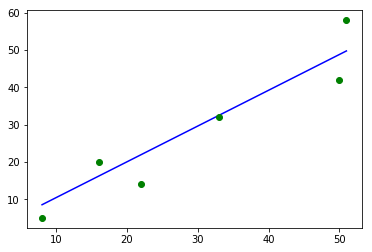

In [27]:
x = np.array([8, 16, 22, 33, 50, 51])
y = np.array([5, 20, 14, 32, 42, 58])

# add your code here
from random import randrange

# generate array of predictions 
def getY_pred(x_data,m,b):
    y_pred = []
    for x in x_data:
        y_pred.append((m*x)+b)
    return y_pred

# MSE function - calculate Mean Squared Error 
def MSE(x_data,y_data, theta):
    
    # genearate predictions
    y_pred_array = np.asarray(getY_pred(x_data,theta[0],theta[1]))
    
    # calculate error 
    return(1/2*len(y_data) * np.sum(np.square(y_pred_array - y_data)))

#Stochastic Gradient Descent function 
def sdg(x,y, initial_theta, initialStep):
    #constants
    MAX_GEN_NO_CHANGE = 50
    STEP_DECREASE_RATE = 0.9
    
    gens_no_change = 0 
    theta = initial_theta
    steps = 0
    minTheta = initial_theta
    endState = False 
    minValue = 1000000
    step = initialStep
    
    while not endState:
        # caculate MSE for new hypothesis 
        value = MSE(x,y,theta)
        
      
        # validate hypothesis 
        if value < minValue:
            # update values if hypothesis is better 
            minValue = value
            minTheta = theta
            gens_no_change = 0 
            step = initialStep
            
            
        else:
            # if hypothesis not beter then update 
            gens_no_change += 1 
            # reduce step size    
            step = step*STEP_DECREASE_RATE
        
    
        
            
        # update params with gradient functions  
        rand_val = randrange(len(x)) 
        x_choice = x[rand_val]
        y_choice = y[rand_val]
        gradient_m = ( -2 * x_choice * (y_choice - (theta[0]*x_choice + theta[1])))
        gradient_b = ( -2 * (y_choice - (theta[0]*x_choice + theta[1])))
        theta = (theta[0] - step * gradient_m ,
                 theta[1] - step * gradient_b)
    
        endState = gens_no_change >= MAX_GEN_NO_CHANGE 
        steps +=1
         
        

    
    print("Generations :",steps)
    print("Minimum Error :",MSE(x,y,minTheta))
    print("Slope :", theta[0]," Intercept :", theta[1] )
    
    return minTheta
      
# use SGD to fit line to data     
minTheta = sdg(x,y,(2,0),0.001)

# plot results 
plt.plot(x,getY_pred(x,minTheta[0],minTheta[1]), color='blue')
plt.plot(x, y, 'o', color='green');


# Stochastic Gradient Descent Mean Squared Error 

The above code fits a line to the X and Y data given at the begining of the code block. One method to fit a line to this type of data is to use Stochastic Gradient Descent (SGD) and the Mean Squared Error (MSE) function. With this method we use the MSE function, which calculates the distance between the data values and the predictions from our hypothesis then square and take the mean of the values. The error produced by the MSE function is used to grade our hypothesis. If we look at the code above there are two functions one to generate the array of predictions and another to apply the error function to the model. The main function in the cell is the SGD function, this carries out the minimization,it takes the x and y datasets, an initial theta tuple the initial step size. The function stores the max number of steps with no improvement and the reduction param for the step size as constants. The SGD function then sets up some initial values and begins the main loop. The function uses the endstate variable to determine wether it has reached a minimum value and can return the calculated theta value the MAX_GEN_NO_CHANGE constant is used to trigger the end of the loop once the set number of generations have occured with no improvement in the hypothesis. The first statment in the loop generates the MSE error for the current hypothesis using the helper functions. The MSE is then evaluated if the error is less than the previous minimum value the minimum error and theta are updated and the step size is set back to its initial value. The step size is reset to increase the likleyhood that the function will find a better result, if the step size is allowed to become too small it may never reach an optimal hypothesis. If the hypothesis is not an improvement the the step size is decreased and the count of steps without improvement is increased. After the hypothesis is evaluated the theta values are updated. In this function both the slope and the intercept are updated based on there own gradient functions which are derived from the MSE function. The gradient values are then multiplied with the step value and subtracted from the two theta values to get the new hypothesis. 
Once enonough generations with no improvement have passed the end condition is set and the loop ends the function then prints some details of the process to the console and returns the selected theta value. 
Finaly this value along with the provided x and y data points are polted to give a visual representation of the results. 
 

# References

1. https://medium.com/@rrfd/what-is-maximum-likelihood-estimation-examples-in-python-791153818030
2. [Section 4.1 - Numerical computation](https://www.deeplearningbook.org/contents/numerical.html)
3. [Bayes for beginners - probability and likelihood](https://www.psychologicalscience.org/observer/bayes-for-beginners-probability-and-likelihood) 